---
<h1><B> Fraud Analytics (CS6890)  </h1></B></center>

---

<table>
<tr>
<td><h3> Assignment : </td>
<td><h3> 5 </td>
</tr>
<tr>
<td><h3> Title : </td>
<td><h3> Synthetic data generation using Variational Autoencoder
 </td>
</tr>
<tr>
<td><h3> Team Details : </td>
<td>

<table>
<tr>
<th> <h3> Name </th>
<th> <h3> Roll Number </th>
</tr>



<tr>
<td><h5> Pramit Sahoo </td>
<td><h5> AI23MTECH14004 </td>
</tr>
<tr>
<td><h5> Tarun Jalota </td>
<td><h5> AI23MTECH13004 </td>
</tr>
<tr>
<td><h5> Pathlavath Shankar </td>
<td><h5> CS21BTECH11064 </td>
</tr>
<tr>
<td><h5> N Sree Harsha </td>
<td><h5> CS21BTECH11042 </td>
</tr>
<tr>
<td><h5> Jayachandra Naidu Rajapu </td>
<td><h5> CS21BTECH11064</td>
</tr>
<tr>


<table>



</td>
</tr>
<table>


In [2]:
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime

import torch    
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd

## Pre-Processing

In [3]:
df = pd.read_csv('/home/ai23mtech14004/CS6890_FraudAnalytics/Assignment_5_SyntheticDataGeneration/card_transaction.v1.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2555190 entries, 0 to 2555189
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use Chip        object 
 8   Merchant Name   float64
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             float64
 13  Errors?         object 
 14  Is Fraud?       object 
dtypes: float64(3), int64(5), object(7)
memory usage: 292.4+ MB


In [6]:
# Calculate the number of unique users
unique_users = df['User'].nunique()

# Handle NaN and non-string types before applying string methods in 'Is Fraud?'
df['Is Fraud?'] = df['Is Fraud?'].apply(lambda x: x.strip().lower() == 'yes' if isinstance(x, str) else False)

# Calculate the number of fraudulent transactions
fraudulent_transactions_count = df['Is Fraud?'].sum()

# Calculate the percentage of fraudulent transactions
fraudulent_transactions_percentage = (fraudulent_transactions_count / len(df)) * 100

# Print the results
print(f"Unique users: {unique_users}")
print(f"Number of fraudulent transactions: {fraudulent_transactions_count}")
print(f"Percentage of fraudulent transactions: {fraudulent_transactions_percentage:.2f}%")


Unique users: 216
Number of fraudulent transactions: 2963
Percentage of fraudulent transactions: 0.12%


In [14]:
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3.527213e+18,La Verne,CA,91750.0,5300.0,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-7.276121e+17,Monterey Park,CA,91754.0,5411.0,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-7.276121e+17,Monterey Park,CA,91754.0,5411.0,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3.414527e+18,Monterey Park,CA,91754.0,5651.0,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5.817218e+18,La Verne,CA,91750.0,5912.0,NaN,No


In [15]:
dfLenOG =len(df)

Checking the stats of the dataset

In [16]:
df.describe()

,User,Card,Year,Month,Day,Merchant Name,Zip,MCC
count,2.555190e+06,2.555190e+06,2.555190e+06,2.555190e+06,2.555190e+06,2.555189e+06,2.216985e+06,2.555189e+06
mean,1.020676e+02,1.238151e+00,2.011793e+03,6.520146e+00,1.571605e+01,-5.783186e+17,5.306903e+04,5.563812e+03
std,6.215434e+01,1.344876e+00,5.150918e+00,3.470954e+00,8.790976e+00,4.731351e+18,2.851758e+04,8.973669e+02
min,0.000000e+00,0.000000e+00,1.995000e+03,1.000000e+00,1.000000e+00,-9.222265e+18,1.001000e+03,1.711000e+03
25%,4.800000e+01,0.000000e+00,2.008000e+03,3.000000e+00,8.000000e+00,-4.693980e+18,3.053500e+04,5.300000e+03
50%,1.010000e+02,1.000000e+00,2.012000e+03,7.000000e+00,1.600000e+01,-9.844448e+17,4.837500e+04,5.499000e+03
75%,1.560000e+02,2.000000e+00,2.016000e+03,1.000000e+01,2.300000e+01,3.102660e+18,7.863300e+04,5.813000e+03
max,2.150000e+02,8.000000e+00,2.020000e+03,1.200000e+01,3.100000e+01,9.222877e+18,9.992800e+04,9.402000e+03


Finding NA Value count in each column

In [17]:
df.isna().sum()

User                    0
Card                    0
Year                    0
Month                   0
Day                     0
Time                    0
Amount                  1
Use Chip                1
Merchant Name           1
Merchant City           1
Merchant State     321041
Zip                338205
MCC                     1
Errors?           2515428
Is Fraud?               1
dtype: int64

In [18]:
#Upon inspection, The NA Value in `Errors?` Column is very high. Calculating the percentage of NA values in `Errors?` Column
df['Errors?'].isna().sum()/len(df)

0.9844387305836356

In [19]:
df = df.drop(['Errors?'],axis=1)

In [20]:
df.isna().sum()

User                   0
Card                   0
Year                   0
Month                  0
Day                    0
Time                   0
Amount                 1
Use Chip               1
Merchant Name          1
Merchant City          1
Merchant State    321041
Zip               338205
MCC                    1
Is Fraud?              1
dtype: int64

Checking for the 1 NA value in the amount column to drop it

In [21]:
df['Amount'][df['Amount'].isnull()].index

Index([2555189], dtype='int64')

In [22]:
df = df.drop(index=[2555189])

In [23]:
df.isna().sum()

User                   0
Card                   0
Year                   0
Month                  0
Day                    0
Time                   0
Amount                 0
Use Chip               0
Merchant Name          0
Merchant City          0
Merchant State    321040
Zip               338204
MCC                    0
Is Fraud?              0
dtype: int64

Upon dropping row 2555189, the NA values in `Amount`, `Use Chip`, `Merchant Name`, `Merchant City`, `MCC` and `Is Fraud?` were also 0. This implies that the row 2555189 was containing all null values

In [24]:
df['Merchant State'].unique()

array(['CA', nan, 'NE', 'IL', 'MO', 'Switzerland', 'IA', 'TX', 'Estonia',
       'NJ', 'NV', 'NY', 'Japan', 'AZ', 'UT', 'FL', 'MI', 'Mexico', 'WA',
       'OH', 'Dominican Republic', 'NM', 'China', 'SC', 'AK', 'PA', 'VA',
       'Portugal', 'HI', 'CT', 'MA', 'MN', 'CO', 'Italy', 'GA',
       'Philippines', 'Jamaica', 'AR', 'Canada', 'OR', 'WI', 'NC',
       'France', 'WV', 'Norway', 'ME', 'NH', 'VT', 'MD', 'AL', 'KY', 'TN',
       'MS', 'New Zealand', 'Netherlands', 'KS', 'ND', 'DC',
       'Sierra Leone', 'Haiti', 'MT', 'South Korea', 'Spain', 'OK',
       'Algeria', 'Egypt', 'WY', 'ID', 'Indonesia', 'RI',
       'United Kingdom', 'Colombia', 'South Africa', 'IN', 'The Bahamas',
       'Singapore', 'Pakistan', 'Malaysia', 'Mongolia', 'Israel',
       'Hong Kong', 'Guatemala', 'Peru', 'Thailand', 'Sweden', 'Taiwan',
       'LA', 'Germany', 'Czech Republic', 'India', 'Poland', 'DE',
       'Costa Rica', 'Denmark', 'Bangladesh', 'Macedonia', 'Nigeria',
       'SD', 'Tuvalu', 'Ireland', '

In [25]:
df['Merchant State'].isna().sum()/len(df), df['Zip'].isna().sum()/len(df)

(0.12564236931201567, 0.13235968063419185)

Only 12 - 13% values were NA in `Merchant State` and `Zip` Column. Dropping them

In [26]:
df = df.dropna()

In [27]:
df.isna().sum()

User              0
Card              0
Year              0
Month             0
Day               0
Time              0
Amount            0
Use Chip          0
Merchant Name     0
Merchant City     0
Merchant State    0
Zip               0
MCC               0
Is Fraud?         0
dtype: int64

In [28]:
len(df)/dfLenOG

0.867639979805807

After dropping all the NA value columns, we are still able to retai >86% of the data

In [29]:
converted = []
for i in df['Time'].values:

    xs = i.replace(":","")
    if len(xs)>1:
        
        converted.append(int(xs))



In [30]:
df['Time_Num'] = converted


In [31]:
df = df.drop(['Time'],axis=1)

In [32]:
df.head()

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,Time_Num
0,0,0,2002,9,1,$134.09,Swipe Transaction,3.527213e+18,La Verne,CA,91750.0,5300.0,No,621
1,0,0,2002,9,1,$38.48,Swipe Transaction,-7.276121e+17,Monterey Park,CA,91754.0,5411.0,No,642
2,0,0,2002,9,2,$120.34,Swipe Transaction,-7.276121e+17,Monterey Park,CA,91754.0,5411.0,No,622
3,0,0,2002,9,2,$128.95,Swipe Transaction,3.414527e+18,Monterey Park,CA,91754.0,5651.0,No,1745
4,0,0,2002,9,3,$104.71,Swipe Transaction,5.817218e+18,La Verne,CA,91750.0,5912.0,No,623


In [33]:
df.dtypes

User                int64
Card                int64
Year                int64
Month               int64
Day                 int64
Amount             object
Use Chip           object
Merchant Name     float64
Merchant City      object
Merchant State     object
Zip               float64
MCC               float64
Is Fraud?          object
Time_Num            int64
dtype: object

In [34]:
df.head()

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,Time_Num
0,0,0,2002,9,1,$134.09,Swipe Transaction,3.527213e+18,La Verne,CA,91750.0,5300.0,No,621
1,0,0,2002,9,1,$38.48,Swipe Transaction,-7.276121e+17,Monterey Park,CA,91754.0,5411.0,No,642
2,0,0,2002,9,2,$120.34,Swipe Transaction,-7.276121e+17,Monterey Park,CA,91754.0,5411.0,No,622
3,0,0,2002,9,2,$128.95,Swipe Transaction,3.414527e+18,Monterey Park,CA,91754.0,5651.0,No,1745
4,0,0,2002,9,3,$104.71,Swipe Transaction,5.817218e+18,La Verne,CA,91750.0,5912.0,No,623


In [35]:
df['Amount'].unique()

array(['$134.09', '$38.48', '$120.34', ..., '$391.10', '$293.51',
       '$296.08'], dtype=object)

In [36]:
len(df['Amount'])

2216985

In [37]:
converted = []
for i in tqdm(df['Amount'].values):
    if type(i) == str:
        
        xs = i.strip('$')
        
        converted.append(float(xs))

100%|██████████| 2216985/2216985 [00:01<00:00, 1578827.91it/s]


In [38]:
converted = np.array(converted)

In [39]:
# df = df.drop(['AmountX'],axis=1)
df['AmountX'] = converted

In [40]:
df = df.drop(['Amount'],axis=1)

In [41]:
df.head()

,User,Card,Year,Month,Day,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,Time_Num,AmountX
0,0,0,2002,9,1,Swipe Transaction,3.527213e+18,La Verne,CA,91750.0,5300.0,No,621,134.09
1,0,0,2002,9,1,Swipe Transaction,-7.276121e+17,Monterey Park,CA,91754.0,5411.0,No,642,38.48
2,0,0,2002,9,2,Swipe Transaction,-7.276121e+17,Monterey Park,CA,91754.0,5411.0,No,622,120.34
3,0,0,2002,9,2,Swipe Transaction,3.414527e+18,Monterey Park,CA,91754.0,5651.0,No,1745,128.95
4,0,0,2002,9,3,Swipe Transaction,5.817218e+18,La Verne,CA,91750.0,5912.0,No,623,104.71


In [42]:
df.dtypes

User                int64
Card                int64
Year                int64
Month               int64
Day                 int64
Use Chip           object
Merchant Name     float64
Merchant City      object
Merchant State     object
Zip               float64
MCC               float64
Is Fraud?          object
Time_Num            int64
AmountX           float64
dtype: object

Giving rest of the columns to Label Encoder

In [43]:
toEncode = ['Use Chip','Merchant Name','Merchant City','Merchant State','Is Fraud?']

for i in toEncode:
    label_encoder = LabelEncoder()
    df[i] = label_encoder.fit_transform(df[i])



In [44]:
df.head()

,User,Card,Year,Month,Day,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,Time_Num,AmountX
0,0,0,2002,9,1,1,15108,3654,4,91750.0,5300.0,0,621,134.09
1,0,0,2002,9,1,1,10137,4552,4,91754.0,5411.0,0,642,38.48
2,0,0,2002,9,2,1,10137,4552,4,91754.0,5411.0,0,622,120.34
3,0,0,2002,9,2,1,14970,4552,4,91754.0,5651.0,0,1745,128.95
4,0,0,2002,9,3,1,17876,3654,4,91750.0,5912.0,0,623,104.71


In [45]:
df.dtypes

User                int64
Card                int64
Year                int64
Month               int64
Day                 int64
Use Chip            int64
Merchant Name       int64
Merchant City       int64
Merchant State      int64
Zip               float64
MCC               float64
Is Fraud?           int64
Time_Num            int64
AmountX           float64
dtype: object

In [46]:
na_count = df.isna().sum()


print("Columns with NA values and their counts:")
print(na_count)

Columns with NA values and their counts:
User              0
Card              0
Year              0
Month             0
Day               0
Use Chip          0
Merchant Name     0
Merchant City     0
Merchant State    0
Zip               0
MCC               0
Is Fraud?         0
Time_Num          0
AmountX           0
dtype: int64


In [48]:
df.to_csv('/home/ai23mtech14004/CS6890_FraudAnalytics/Assignment_5_SyntheticDataGeneration/new_good_data.csv')

## Reading the Pre-Processed CSV

In [49]:
df = pd.read_csv('/home/ai23mtech14004/CS6890_FraudAnalytics/Assignment_5_SyntheticDataGeneration/new_good_data.csv',)

In [50]:
df = df.drop('Unnamed: 0',axis=1)
df.head()

,User,Card,Year,Month,Day,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,Time_Num,AmountX
0,0,0,2002,9,1,1,15108,3654,4,91750.0,5300.0,0,621,134.09
1,0,0,2002,9,1,1,10137,4552,4,91754.0,5411.0,0,642,38.48
2,0,0,2002,9,2,1,10137,4552,4,91754.0,5411.0,0,622,120.34
3,0,0,2002,9,2,1,14970,4552,4,91754.0,5651.0,0,1745,128.95
4,0,0,2002,9,3,1,17876,3654,4,91750.0,5912.0,0,623,104.71


In [51]:
len(list(df.columns))

14

In [52]:
len(df)

2216985

## Normalizing the Values

Using Standard Scaler to Normalize the values, as the assumption of VAE is that the latent space follows gaussian distribution

In [53]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df.values)
normalized_dataframe = pd.DataFrame(normalized_data, columns=df.columns)

In [54]:
normalized_dataframe.head()

,User,Card,Year,Month,Day,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,Time_Num,AmountX
0,-1.667172,-0.932706,-1.867914,0.712584,-1.674383,0.630024,0.822126,-0.097789,-1.191026,1.356391,-0.399476,-0.015361,-1.295325,1.111510
1,-1.667172,-0.932706,-1.867914,0.712584,-1.674383,0.630024,-0.054085,0.298392,-1.191026,1.356531,-0.274037,-0.015361,-1.253902,-0.053743
2,-1.667172,-0.932706,-1.867914,0.712584,-1.560579,0.630024,-0.054085,0.298392,-1.191026,1.356531,-0.274037,-0.015361,-1.293352,0.943931
3,-1.667172,-0.932706,-1.867914,0.712584,-1.560579,0.630024,0.797802,0.298392,-1.191026,1.356531,-0.002817,-0.015361,0.921802,1.048865
4,-1.667172,-0.932706,-1.867914,0.712584,-1.446775,0.630024,1.310027,-0.097789,-1.191026,1.356391,0.292135,-0.015361,-1.291380,0.753439


In [55]:
df.head()

,User,Card,Year,Month,Day,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,Time_Num,AmountX
0,0,0,2002,9,1,1,15108,3654,4,91750.0,5300.0,0,621,134.09
1,0,0,2002,9,1,1,10137,4552,4,91754.0,5411.0,0,642,38.48
2,0,0,2002,9,2,1,10137,4552,4,91754.0,5411.0,0,622,120.34
3,0,0,2002,9,2,1,14970,4552,4,91754.0,5651.0,0,1745,128.95
4,0,0,2002,9,3,1,17876,3654,4,91750.0,5912.0,0,623,104.71


In [56]:
df = normalized_dataframe

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [58]:
device

device(type='cuda')

## Varitational Autoencoder

### Model Definition

In [59]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
        )

        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_var = nn.Linear(256, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, input_dim),

        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        log_var = self.fc_var(encoded)
        z = self.reparameterize(mu, log_var)
        decoded = self.decoder(z)
        return decoded, mu, log_var



class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data.values.astype(float)
        self.scaler = StandardScaler()
        self.data = self.scaler.fit_transform(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)


In [60]:
input_dim = len(df.columns)
hidden_dim = 1024
latent_dim = 128
lr = 1e-3
batch_size = 512
num_epochs = 25


vae = VAE(input_dim, latent_dim)



In [61]:
optimizer = optim.Adam(vae.parameters(), lr=lr)

custom_dataset = CustomDataset(df)
dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)




In [62]:
def loss_function(recon_x, x, mu, logvar):

    mse_loss = nn.MSELoss(reduction='sum')
    MSE = mse_loss(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD.to(device)

    return MSE + KLD

In [63]:
vals = next(iter(dataloader))

In [64]:
vals.shape

torch.Size([512, 14])

In [65]:
vae = vae.to(device)

### Training 

In [66]:
vae.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, data in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()

        recon_batch, mu, logvar = vae(data.to(device))
        
        loss = loss_function(recon_batch.to(device), data.to(device), mu.to(device), logvar.to(device))
        loss.backward()
        
        total_loss += loss.detach().cpu().item()/batch_size
        optimizer.step()
    # if epoch%50==0:
    print('Epoch {}, Loss: {:.2f}'.format(epoch+1, total_loss / len(dataloader)))
        


0it [00:00, ?it/s]

4331it [00:44, 97.41it/s] 


Epoch 1, Loss: 13.95


4331it [00:43, 100.25it/s]


Epoch 2, Loss: 10.89


4331it [00:40, 106.25it/s]


Epoch 3, Loss: 10.29


4331it [00:48, 88.96it/s] 


Epoch 4, Loss: 10.30


4331it [00:47, 91.90it/s] 


Epoch 5, Loss: 10.05


4331it [00:42, 101.44it/s]


Epoch 6, Loss: 10.21


4331it [00:41, 105.57it/s]


Epoch 7, Loss: 9.91


4331it [00:42, 102.81it/s]


Epoch 8, Loss: 9.96


4331it [00:43, 98.86it/s] 


Epoch 9, Loss: 9.85


4331it [00:45, 94.51it/s] 


Epoch 10, Loss: 9.82


4331it [00:49, 88.00it/s] 


Epoch 11, Loss: 9.79


4331it [00:45, 96.10it/s] 


Epoch 12, Loss: 9.78


4331it [00:45, 94.42it/s] 


Epoch 13, Loss: 9.76


4331it [00:44, 96.41it/s] 


Epoch 14, Loss: 9.75


4331it [00:50, 85.65it/s] 


Epoch 15, Loss: 9.74


4331it [00:43, 100.02it/s]


Epoch 16, Loss: 9.73


4331it [00:42, 102.85it/s]


Epoch 17, Loss: 9.73


4331it [00:46, 92.31it/s] 


Epoch 18, Loss: 9.72


4331it [00:42, 102.55it/s]


Epoch 19, Loss: 9.72


4331it [00:42, 102.56it/s]


Epoch 20, Loss: 9.71


4331it [00:46, 92.98it/s] 


Epoch 21, Loss: 9.71


4331it [00:42, 102.37it/s]


Epoch 22, Loss: 9.71


4331it [00:42, 101.42it/s]


Epoch 23, Loss: 9.70


4331it [00:41, 103.79it/s]


Epoch 24, Loss: 9.70


4331it [00:48, 89.31it/s] 

Epoch 25, Loss: 9.70


### Saving the Model

In [67]:
f"{total_loss / len(dataloader):.2f}"

'9.70'

In [68]:
current_time = datetime.datetime.now()

In [73]:
root = '/home/ai23mtech14004/CS6890_FraudAnalytics/Assignment_5_SyntheticDataGeneration'

In [74]:
savePath = f'{root}/{str(current_time).split(".")[0]}-{total_loss / len(dataloader):.2f}-2X.pth'

In [75]:
savePath

'/home/ai23mtech14004/CS6890_FraudAnalytics/Assignment_5_SyntheticDataGeneration/2024-05-02 19:57:00-9.70-2X.pth'

In [76]:
torch.save(vae.state_dict(), savePath)

### Loading the Model

In [78]:
vae.load_state_dict(torch.load('/home/ai23mtech14004/CS6890_FraudAnalytics/Assignment_5_SyntheticDataGeneration/2024-05-02 19:57:00-9.70-2X.pth'))


<All keys matched successfully>

In [79]:
len(df)

2216985

In [80]:
device = 'cpu' #Sending the model to cpu to generate >2 Million samples as the GPU VRAM gets full.

In [81]:
vae.to(device)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=14, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
  )
  (fc_mu): Linear(in_features=256, out_features=128, bias=True)
  (fc_var): Linear(in_features=256, out_features=128, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, ou

## Generating Synthetic Data

In [82]:
num_samples = len(df)
z_samples = torch.randn(num_samples, 128)

with torch.no_grad():
    generated_data = vae.decoder(z_samples.to(device)).cpu().numpy()
generated_df = pd.DataFrame(generated_data, columns=df.columns)


In [83]:
generated_df.head()

,User,Card,Year,Month,Day,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,Time_Num,AmountX
0,0.281006,0.112855,0.449398,0.442254,-1.056524,0.303730,-0.899201,0.948262,-0.683853,0.777892,-0.345565,0.017208,0.079178,0.175440
1,-0.969588,1.657131,-0.908314,-0.269679,0.466485,0.615268,-0.846056,0.354773,-0.828601,-0.368986,-0.226749,-0.020696,0.347564,-0.114135
2,-0.342690,-0.453999,0.016570,0.612651,-0.190398,0.598286,0.022785,0.016062,0.716940,-0.575541,-0.010197,-0.015852,-0.442483,-0.260100
3,0.140016,0.317855,-0.877203,0.231578,-0.512958,0.586545,-1.078290,0.146159,-0.789896,0.086990,-0.156090,0.005905,0.330588,-0.126605
4,0.935204,-0.583300,0.102907,0.828548,-1.161082,0.608203,-0.152778,0.278216,0.177716,-0.617618,0.468613,-0.017964,-0.099327,-0.226208


In [84]:
df.head()

,User,Card,Year,Month,Day,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,Time_Num,AmountX
0,-1.667172,-0.932706,-1.867914,0.712584,-1.674383,0.630024,0.822126,-0.097789,-1.191026,1.356391,-0.399476,-0.015361,-1.295325,1.111510
1,-1.667172,-0.932706,-1.867914,0.712584,-1.674383,0.630024,-0.054085,0.298392,-1.191026,1.356531,-0.274037,-0.015361,-1.253902,-0.053743
2,-1.667172,-0.932706,-1.867914,0.712584,-1.560579,0.630024,-0.054085,0.298392,-1.191026,1.356531,-0.274037,-0.015361,-1.293352,0.943931
3,-1.667172,-0.932706,-1.867914,0.712584,-1.560579,0.630024,0.797802,0.298392,-1.191026,1.356531,-0.002817,-0.015361,0.921802,1.048865
4,-1.667172,-0.932706,-1.867914,0.712584,-1.446775,0.630024,1.310027,-0.097789,-1.191026,1.356391,0.292135,-0.015361,-1.291380,0.753439


In [85]:
len(df.columns)

14

In [86]:
generated_df.to_csv('/home/ai23mtech14004/CS6890_FraudAnalytics/Assignment_5_SyntheticDataGeneration/generated_data_1.csv')

## Results

### Comparison with Original Data

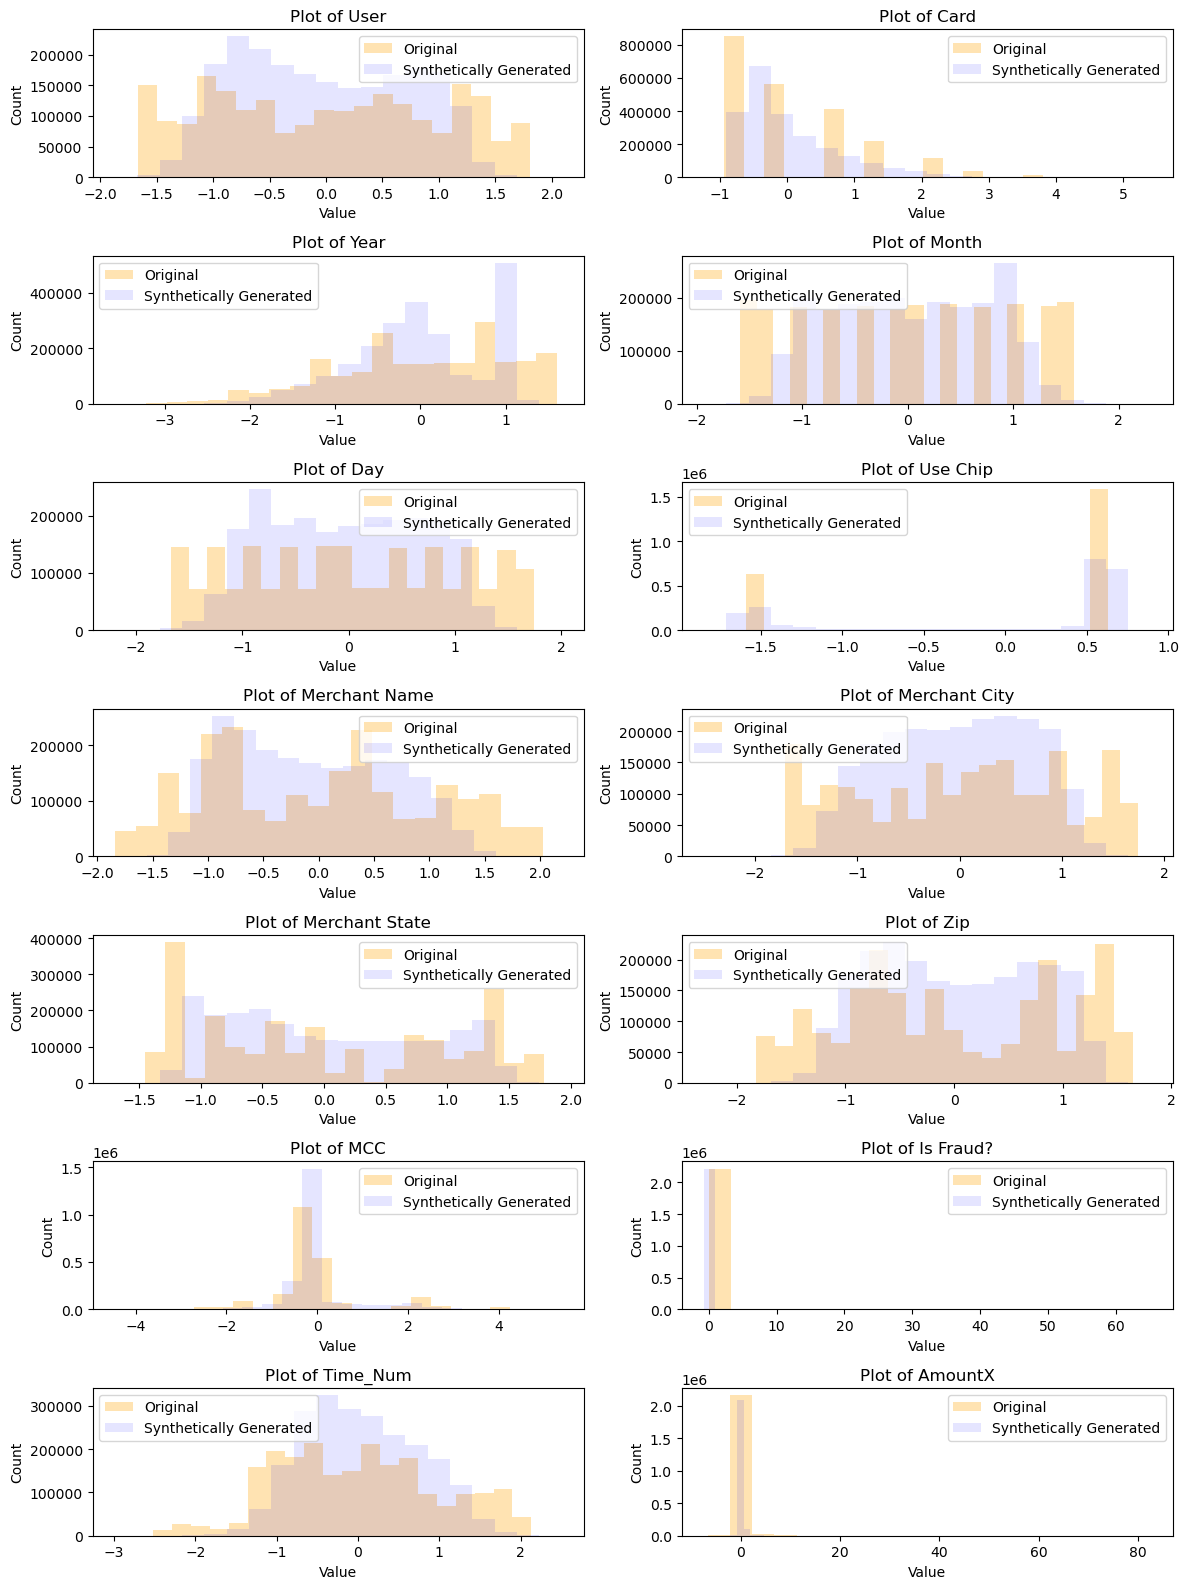

In [87]:
import matplotlib.pyplot as plt
import numpy as np

num_histograms = len(df.columns)

fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(12, 16))
axs = axs.flatten()


for i in range(num_histograms):
    axs[i].hist(df[df.columns[i]].values, bins=20, color='orange', alpha=0.3, label='Original')
    
    
    # axs[i].hist(scale_value(generated_df[df.columns[i]].values), bins=20, color='blue', alpha=0.1, label='Histogram 2')
    axs[i].hist(generated_df[df.columns[i]].values, bins=20, color='blue', alpha=0.1, label='Synthetically Generated')
    
    axs[i].set_title(f'Plot of {df.columns[i]}')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Count')
    axs[i].legend()


for i in range(num_histograms, len(axs)):
    axs[i].axis('off')


plt.tight_layout()


plt.show()


In [88]:
colList = list(df.columns)

In [89]:
def mse(y_true, y_pred):
    return np.mean(np.square(np.sort(y_true) - np.sort(y_pred)))

MSE

In [90]:
MSEs = []

for i in list(df.columns):

    mseVal = mse(df[i].values, generated_df[i].values)

    print(f"MSE for {i}:", mseVal)
    MSEs.append(mseVal)
MSEs = np.array(MSEs)

MSE for User: 0.07046667703435938
MSE for Card: 0.1198466011325095
MSE for Year: 0.06814461911958836
MSE for Month: 0.0862397273350159
MSE for Day: 0.08584125748242542
MSE for Use Chip: 0.05076748468010624
MSE for Merchant Name: 0.09471854207512159
MSE for Merchant City: 0.09921563512079695
MSE for Merchant State: 0.04578501883068713
MSE for Zip: 0.08206956030787248
MSE for MCC: 0.11514243123235884
MSE for Is Fraud?: 0.9446066205352812
MSE for Time_Num: 0.09541883313947591
MSE for AmountX: 0.3047201768159431


In [91]:
print(f'MSE for full Data: {np.mean(MSEs)}')

MSE for full Data: 0.16164165606011016


In [92]:
for i in list(df.columns):
    if len(list(df[i].unique()))<50:
        print(f'{df[i].unique()}, {i}')

[-0.93270616 -0.19355703  0.54559211  1.28474124  2.02389038  2.76303951
  3.50218865  4.24133778  4.98048691], Card
[-1.8679139  -1.67527281 -1.48263172 -1.28999064 -1.09734955 -0.90470846
 -0.71206737 -0.51942628 -0.32678519 -0.1341441   0.05849699  0.25113808
  0.44377917  0.63642025  0.82906134  1.02170243  1.21434352  1.40698461
  1.5996257  -2.44583717 -2.25319608 -2.06055499 -2.63847826 -3.02376044
 -2.83111935 -3.21640152], Year
[ 0.71258382  1.00050188  1.28841993  1.57633798 -1.59076061 -1.30284255
 -1.0149245  -0.72700645 -0.43908839 -0.15117034  0.13674772  0.42466577], Month
[-1.67438307 -1.56057901 -1.44677495 -1.3329709  -1.21916684 -1.10536278
 -0.99155872 -0.87775467 -0.76395061 -0.65014655 -0.53634249 -0.42253843
 -0.30873438 -0.19493032 -0.08112626  0.0326778   0.14648185  0.26028591
  0.37408997  0.48789403  0.60169808  0.71550214  0.8293062   0.94311026
  1.05691432  1.17071837  1.28452243  1.39832649  1.51213055  1.6259346
  1.73973866], Day
[ 0.63002442 -1.587240

### Quantizing Synthetic Data
Quantizing Synthetic Data values whose categories are <50

In [93]:
def round_to_nearest(value, value_list):
    return value_list[np.abs(value_list - value).argmin()]

In [94]:
def returnQuantized(df,dfGen):
    colstoQuantize = ['Card',	'Year'	,'Month',	'Day'	,'Use Chip', 'Is Fraud?']

    quantized_dfGen = dfGen
    for i in tqdm(colstoQuantize):

        x = dfGen[i].values
        
        value_list = list(df[i].unique())

        rounded_values = np.array([round_to_nearest(value=val, value_list=value_list) for val in x])
        
        quantized_dfGen[i] = rounded_values


    return quantized_dfGen

In [95]:
qdf = returnQuantized(df,generated_df)

100%|██████████| 6/6 [01:21<00:00, 13.58s/it]


In [96]:
qdf

,User,Card,Year,Month,Day,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,Time_Num,AmountX
0,0.281006,-0.193557,0.443779,0.424666,-1.105363,0.630024,-0.899201,0.948262,-0.683853,0.777892,-0.345565,-0.015361,0.079178,0.175440
1,-0.969588,2.023890,-0.904708,-0.151170,0.487894,0.630024,-0.846056,0.354773,-0.828601,-0.368986,-0.226749,-0.015361,0.347564,-0.114135
2,-0.342690,-0.193557,0.058497,0.712584,-0.194930,0.630024,0.022785,0.016062,0.716940,-0.575541,-0.010197,-0.015361,-0.442483,-0.260100
3,0.140016,0.545592,-0.904708,0.136748,-0.536342,0.630024,-1.078290,0.146159,-0.789896,0.086990,-0.156090,-0.015361,0.330588,-0.126605
4,0.935204,-0.932706,0.058497,0.712584,-1.105363,0.630024,-0.152778,0.278216,0.177716,-0.617618,0.468613,-0.015361,-0.099327,-0.226208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2216980,1.419578,0.545592,-0.712067,-1.014924,-0.763951,0.630024,-1.162059,-0.317552,0.377765,-1.071459,-0.355888,-0.015361,-0.852775,0.180238
2216981,0.014640,-0.932706,0.829061,-0.151170,-0.081126,-1.587240,-0.485145,0.639417,1.295579,1.062342,-0.052302,-0.015361,1.197418,-0.002154
2216982,0.938202,-0.193557,-0.134144,1.000502,0.487894,0.630024,-0.994646,-0.061548,0.413011,-0.868320,-0.053851,-0.015361,-0.727028,-0.172785
2216983,-0.719826,-0.193557,-0.134144,1.000502,1.056914,0.630024,0.780797,0.344885,-0.982420,0.652356,-0.040334,-0.015361,0.143342,-0.101714


In [98]:
qdf.columns

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Use Chip', 'Merchant Name',
       'Merchant City', 'Merchant State', 'Zip', 'MCC', 'Is Fraud?',
       'Time_Num', 'AmountX'],
      dtype='object')

In [100]:
qdf.to_csv('/home/ai23mtech14004/CS6890_FraudAnalytics/Assignment_5_SyntheticDataGeneration/qdf_generated_data.csv')

### Comparing the Quantised Data with the original

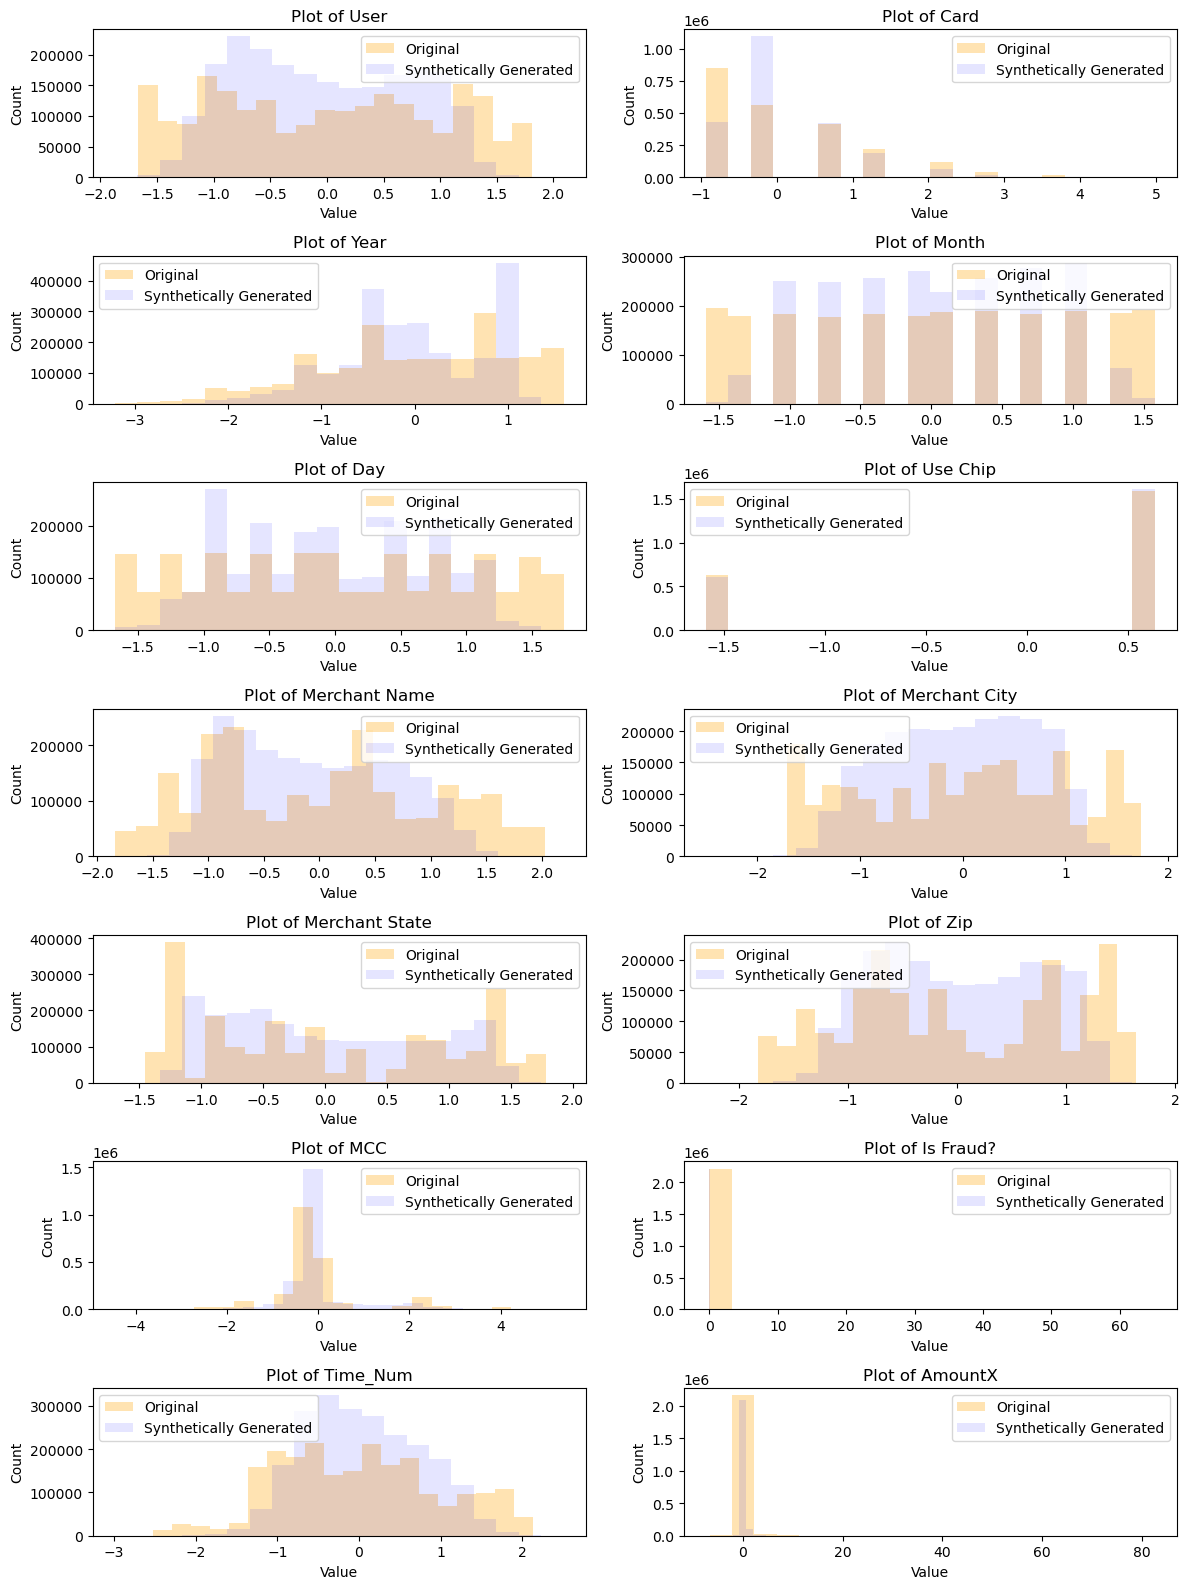

In [101]:
import matplotlib.pyplot as plt
import numpy as np

num_histograms = len(df.columns)

fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(12, 16))
axs = axs.flatten()


for i in range(num_histograms):
    axs[i].hist(df[df.columns[i]].values, bins=20, color='orange', alpha=0.3, label='Original')
    
    
    axs[i].hist(qdf[df.columns[i]].values, bins=20, color='blue', alpha=0.1, label='Synthetically Generated')
    
    axs[i].set_title(f'Plot of {df.columns[i]}')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Count')
    axs[i].legend()


for i in range(num_histograms, len(axs)):
    axs[i].axis('off')


plt.tight_layout()


plt.show()


In [102]:
MSEs = []

for i in list(df.columns):

    mseVal = mse(df[i].values, qdf[i].values)

    print(f"MSE for {i}:", mseVal)
    MSEs.append(mseVal)
MSEs = np.array(MSEs)

MSE for User: 0.07046667703435938
MSE for Card: 0.19566549048236342
MSE for Year: 0.07216879987022938
MSE for Month: 0.09158610991229205
MSE for Day: 0.08687871430141769
MSE for Use Chip: 0.05043138597688299
MSE for Merchant Name: 0.09471854207512159
MSE for Merchant City: 0.09921563512079695
MSE for Merchant State: 0.04578501883068713
MSE for Zip: 0.08206956030787248
MSE for MCC: 0.11514243123235884
MSE for Is Fraud?: 1.0002359616361582
MSE for Time_Num: 0.09541883313947591
MSE for AmountX: 0.3047201768159431


In [103]:
print(f'MSE for full Data: {np.mean(MSEs)}')

MSE for full Data: 0.1717502383382828


### Comparison using coarse grained

In [104]:
train_df = pd.read_csv('/home/ai23mtech14004/CS6890_FraudAnalytics/Assignment_5_SyntheticDataGeneration/new_good_data.csv')
generated_df = pd.read_csv('/home/ai23mtech14004/CS6890_FraudAnalytics/Assignment_5_SyntheticDataGeneration/generated_data_1.csv')
generated_qdf = pd.read_csv('/home/ai23mtech14004/CS6890_FraudAnalytics/Assignment_5_SyntheticDataGeneration/qdf_generated_data.csv')

In [105]:
fullData = pd.concat([train_df,generated_df])

In [106]:
dup_total = len(fullData) - len(fullData.drop_duplicates())

In [107]:
dup_real = len(train_df) - len(train_df.drop_duplicates())

In [108]:
dup_real

0

In [109]:
dup_synthetic = len(generated_df) - len(generated_df.drop_duplicates())

In [110]:
dup_synthetic

0

In [111]:
dup_total

0

In [112]:
copies = dup_total - dup_real - dup_synthetic

In [113]:
f'dup_total = {dup_total}, dup_real = {dup_real}'

'dup_total = 0, dup_real = 0'

In [114]:
copies

0

Percentage of duplicates in generated data


In [115]:
print(f'% of synthetic data is a self copy in: {((len(generated_df) - len(generated_df.drop_duplicates())) / len(generated_df))*100}')


% of synthetic data is a self copy in: 0.0


### Comparison using medium grained

In [116]:
import numpy as np
import pandas as pd
from scipy.stats import entropy

def calculate_kl_divergence(data_p, data_q):
    kl_div = entropy(data_p, data_q)
    return kl_div

def calc_hist(data, bins=100):
    hist, bins = np.histogram(data, bins=bins, density=True)
    return hist, bins


train_df = pd.read_csv('/home/ai23mtech14004/CS6890_FraudAnalytics/Assignment_5_SyntheticDataGeneration/new_good_data.csv')
generated_df = pd.read_csv('/home/ai23mtech14004/CS6890_FraudAnalytics/Assignment_5_SyntheticDataGeneration/qdf_generated_data.csv')


train_data = train_df.to_numpy().flatten()
generated_data = generated_df.to_numpy().flatten()

train_hist, train_bins = calc_hist(train_data)
gen_hist, gen_bins = calc_hist(generated_data)

kl_div = calculate_kl_divergence(train_hist, gen_hist)
print("KL Divergence between the original and synthetic dataset:", kl_div)


KL Divergence between the original and synthetic dataset: 0.1384790408781272
